# Shocks and detonations

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 16 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 21 February 2020.

The objective of this tutorial is to show how one can compute the normal shock and detonation wave relationships developed in Chapter 16 of Turns 4th ed. using Cantera. We will use the thermodynamic properties that are included in gri30.cti.

The reader should be familiar with the material in the earlier chapter Notebooks before working through this Notebook.

## 1. Normal shock

We consider the steady one-dimensional adiabatic flow of a constant-property ideal gas, adopting a reference frame in which the shock wave is stationary. A more complete list of assumptions is given in the ONE-DIMENSIONAL ANALYSIS section of Chapter 16 of Turns 4th ed. In this reference frame, the flow upstream of the shock is supersonic (or sonic, in the limiting case), and the flow downstream of the shock is subsonic (or sonic, in the limiting case of sonic upstream flow). 

With these simplifications, the downstream Mach number $M_2$ and the ratios of thermodynamic properties across the shock (pressure ratio $P_2/P_1$, mass density ratio $ \rho_2 / \rho_1 $, and temperature ratio $T_2 / T_1$) are then functions only of the upstream Mach number $M_1$ and of the constant ratio of specific heats $ \gamma \equiv c_p / c_v $. The governing equations are developed in Chapter 3 of J.D. Anderson, "Modern Compressible Flow with Historical Perspective," Third Edition, McGraw Hill (2003), for example.

We don't need really need Cantera yet, but we will go ahead and load the usual modules and define an ideal-gas mixture for later use:

In [1]:
# access modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define an ideal-gas mixture named "gas" using Cantera's "Solution" object and GRI-Mech 3.0
gas = ct.Solution('gri30.cti')

We next define a function that computes the downstream Mach number and the ratios of thermodynamic properties (pressure, density, and temperature) across a normal shock. The equations are given in Chapter 16 of Turns 4th ed., and a full derivation can be found in Chapter 3 of J.D. Anderson, "Modern Compressible Flow with Historical Perspective," Third Edition, McGraw Hill (2003):

In [3]:
# define a function that returns the downstream Mach number and ratios of thermodynamic properties across a normal
#   shock, given the ratio of species heats and the upstream Mach number
def normal_shock(gamma,M1):
    gammam1 = gamma - 1.
    gammap1 = gamma + 1.
    M1sq    = M1*M1
    
    M2       = np.sqrt( ( 1. + 0.5*gammam1*M1sq ) / ( gamma*M1sq - 0.5*gammam1 ) )
    pres_rat = 1. + 2.*gamma*( M1sq - 1. ) / gammap1
    dens_rat = gammap1*M1sq / ( 2. + gammam1*M1sq )
    temp_rat = pres_rat / dens_rat
    return M2,pres_rat,dens_rat,temp_rat    

We then use this function to compute and plot the downstream Mach number and the thermodynamic property ratios as functions of upstream Mach number, for a fixed value of the ratio of specific heats. Here we choose $ \gamma = 1.4 $, which is an appropriate value for diatomic ideal-gas mixtures (e.g., for air):

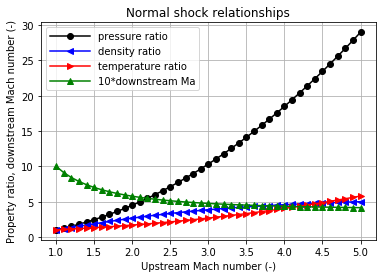

In [4]:
# consider gamma = 1.4
gamma = 1.4

# define arrays for plotting
M1s   = np.arange(1.,5.01,0.1)
nm    = len(M1s)
M2s   = np.zeros(nm)
prat  = np.zeros(nm)
drat  = np.zeros(nm)
trat  = np.zeros(nm)

# compute downstream Mach number and thermodynamic property ratios as functions of upstream Mach number
for i, M1 in enumerate(M1s):
    M2s[i],prat[i],drat[i],trat[i] = normal_shock(gamma,M1)
    
# plot the results
fig, ax = plt.subplots()
ax.plot(M1s, prat,    'k-o', label='pressure ratio'    )
ax.plot(M1s, drat,    'b-<', label='density ratio'     ) 
ax.plot(M1s, trat,    'r->', label='temperature ratio' )
ax.plot(M1s, 10.*M2s, 'g-^', label='10*downstream Ma'  )
ax.set(xlabel='Upstream Mach number (-)',
       ylabel='Property ratio, downstream Mach number (-)',
       title ='Normal shock relationships')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Normal_shock_gamma1.4.pdf")

The results are consistent with those that can be found in standard normal shock tables. For example, see Figure 3.10 or Table A.2 of J.D. Anderson, "Modern Compressible Flow with Historical Perspective," Third Edition, McGraw Hill (2003).

## 2. Rayleigh line

With the assumptions listed in the ONE-DIMENSIONAL ANALYSIS section of Chapter 16 of Turns 4th ed., the continuity and momentum equations can be combined to give a relationship between the pressure and density (or specific volume) upstream of a detonation wave (subscript $1$ quantities) and those downstream of the detonation wave (subscript $2$ quantities). The result can be expressed in terms of the (constant) mass flux $ \dot m '' $ across the detonation wave, giving a linear relationship between the downsteam pressure $P_2$ and the downstream specific volume $v_2$, as shown in Figure 16.2 of Turns 4th ed. For given values of $P_1$, $v_1$, and $ \dot m '' $, and dropping the subscript $2$ for the downstream values, the result can be written as:

$$ P = P_1 - \dot m '' ^ 2 ( v - v_1 ) $$

This defines a line in the $P-v$ plane that passes through the point $ ( v_1 , P_1 ) $ for $ v = v_1 $, and that has a slope equal to $ - \dot m '' ^2 $, so that the slope is inherently negative. This result is used primarily to determine what downstream states are physically realizable for a detonation wave, as discussed in Chapter 16.

For subsequent use, we define a function that returns the pressure downstream of a detonation wave, given the upstream pressure and specific volume, the mass flux through the detonation wave, and the specific volume downstream of the detonation wave:  

In [5]:
# define a function that returns the pressure downstream of a detonation wave, given the pressure and specific volume
#   upstream of the wave, the mass flux through the wave, and the specific volume downstream of the wave
def Rayleigh(P1,v1,mflux,v):
    P = P1 - mflux*mflux*( v - v1 )
    return P

## 3. Rankine-Hugoniot curve

With the same assumptions as those used to develop the equation for a Rayleigh line, and with the additional consideration of the energy equation (in addition to the continuity and momentum equations), another relationship can be derived that relates changes in thermodynamic properties across a detonation wave and the heat release in the wave $q$ (energy per unit mass of working fluid). The result can be plotted as a Rankine-Hugoniot curve in the the $P-v$ plane, as shown in Figure 16.3 of Turns 4th ed. For given values of upstream pressure $P_1$, upstream specific volume $v_1$, heat release $q$, and downstream specific volume $v$, the downstream pressure is given by:

$$ P = \frac { P_1 v_1 \bigl( \frac{\gamma}{\gamma - 1} - \frac{1}{2} \bigr) - \frac {1}{2} P_1 v + q } { \bigl( \frac {\gamma}{\gamma - 1} - \frac {1}{2} \bigr) v - \frac {1}{2} v_1 } $$

This is Equation 16.13b of Turns 4th ed., solving for $P_2$ and dropping the subscript $2$ for the downstream values.

For subsequent use, we define another function that returns the pressure downstream of a detonation wave, given the ratio of specific heats of the working fluid, the heat release across the detonation wave, the upstream pressure and specific volume, and the specific volume downstream of the detonation wave: 

In [6]:
# define a function that returns the pressure downstream of a detonation wave, given the ratio of specific heats, the
#   heat release across the wave, the pressure and specific volume upstream of the wave, and the specific volume 
#   downstream of the wave
def Rankine_Hugoniot(gamma,q,P1,v1,v):
    gfunc = gamma / ( gamma - 1. ) - 0.5
    P     = ( P1*v1*gfunc - 0.5*P1*v + q ) / ( gfunc*v - 0.5*v1 )
    return P

## 4. Example 16.1 of Turns 4th ed.

We now use the functions defined above to solve Example 16.1 of Turns 4th ed. In this case, the required thermodynamic properties are specified directly, and we do not need to use Cantera.

In [7]:
# specify the temperature and pressure of the gas mixture upstream of the combustion wave
T1 = 298.       # {K}
P1 = ct.one_atm # (Pa)

# specify the thermodynamic properties of the gas mixture
MW    = 29.0    # (kg/kmol)
gamma = 1.3     # (-)  

# specify the mass flux and heat release
mflux = 3500.   # (kg/m^2-s)
q     = 3.4e6   # (J/kg)

# compute the specific volume upstream of the combustion wave, using the ideal-gas law
R1 = ct.gas_constant / MW
v1 = R1*T1 / P1
v1

0.843210123042106

The value of the upstream specific volume is consistent with the value given in Example 16.1.

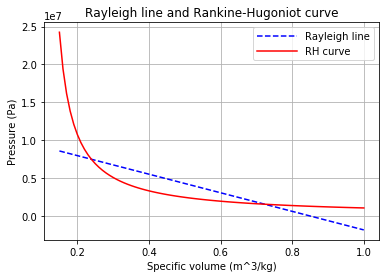

In [8]:
# define a range of specific volumes over which to plot a Rayleigh line and a Rankine-Hugoniot curve
vs   = np.arange(0.15,1.001,0.01)

# define arrays to hold the corresponding pressure-versus-specific-volume values
nvs  = len(vs)
PRay = np.zeros(nvs)
PRH  = np.zeros(nvs)

# compute the Rayleigh line
for i, v in enumerate(vs):
    PRay[i] = Rayleigh(P1,v1,mflux,v)
    
# compute the Rankine-Hugoniot curve
for i, v in enumerate(vs):
    PRH[i] = Rankine_Hugoniot(gamma,q,P1,v1,v)
    
# plot the Rayleigh line and the Rankine-Hugoniot curve for the given conditions
fig, ax = plt.subplots()
ax.plot(vs, PRay, 'b--', label='Rayleigh line' )
ax.plot(vs, PRH,  'r-',  label='RH curve'      )
ax.set(xlabel='Specific volume (m^3/kg)',
       ylabel='Pressure (Pa)',
       title ='Rayleigh line and Rankine-Hugoniot curve')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Ray-RH.pdf")

For the given conditions, the Rayleigh line and the Rankine-Hugoniot curve intersect at two points. Both solutions are physically realizable, as discussed in Chapter 16. 

We could solve the two simultaneous equations for $P$ and $v$ numerically to find the two solutions, but as shown in Chapter 16, in this case the two equations can be manipulated to yield a quadratic equation for the two values of the specific volume that lie both on the Rayleigh line and on the Rankine-Hugoniot curve. Following the approach used in Chapter 16 of Turns 4th ed.:

In [9]:
# compute the values of the coefficients in the quadratic equation for the downstream specific volume
a = 0.5*( 1. + gamma )*mflux*mflux / ( 1. - gamma )
b = gamma*( P1 + mflux*mflux*v1 ) / ( gamma - 1. )
c = gamma*P1*v1 / ( 1. - gamma ) - 0.5*mflux*mflux*v1*v1 - q

term1 = -0.5*b/a
term2 =  0.5*np.sqrt( b*b - 4.*a*c ) / a

v2a = term1 + term2
v2b  = term1 - term2

v2a , v2b

(0.23920925643028682, 0.7233351062632741)

These are consistent with the two values given in Example 16.1. We then compute the corresponding downstream pressures:

In [10]:
P2a = P1 + mflux*mflux*( v1 - v2a )
P2b = P1 + mflux*mflux*( v1 - v2b )

P2a , P2b

(7500335.615994785, 1569793.9555406899)

These are, again, consistent with the results given in Example 16.1. Finally, we compute the two downstream Mach numbers. To do that, we need the upstream and downstream flow speeds, and the upstream and downstream speeds of sound. Recall that we are assuming constant properties, so that the value of the gas constant downstream of the wave (R2) is equal to the value upstream of the wave (R1):

In [11]:
# compute the downstream flow speeds for the two solutions
u2a = mflux*v2a
u2b = mflux*v2b

# compute the downstream temperatures for the two solutions
T2a = P2a*v2a / R1
T2b = P2b*v2b / R1

# compute the downstream sound speeds for the two solutions
c2a = np.sqrt( gamma*R1*T2a )
c2b = np.sqrt( gamma*R1*T2b )

# compute the downstream Mach numbers for the two solutions
M2a = u2a/c2a
M2b = u2b/c2b

M2a , M2b

(0.5482075471779312, 2.0837461659612555)

The results are consistent with those given in Example 16.1.

## 5. Detonation velocity

We next define a function that returns the temperature downstream of a detonation wave, and the speed at which the detonation propagates relative to the upstream gas mixture (which is equal to the speed with which the upstream gas mixture flows into the detonation wave, in a reference frame attached to the wave). For these, we use Equations 16.26 and 16.27 in Turns 4th ed. The equations are not derived in detail there, but the final expressions allow for different specific heats in the upstream gas mixture and in the downstream gas mixture.

In [12]:
# define a function that returns the temperature downstream of a detonation wave and the detonation velocity, given the
#   values of the specific heats in the upstream and downstream gas mixtures, the ratio of specific heats and the gas
#   constant in the downstream mixture, the upstream gas mixture temperature, and the heat release across the wave
def Detonation_T_vel(cp1,cp2,gamma2,R2,T1,q):
    cpterm = cp1*T1/cp2 + q/cp2
    T2     = 2.*gamma2*gamma2*cpterm / ( gamma2 + 1. )
    vD     = np.sqrt( 2.*( gamma2 + 1. )*gamma2*R2*cpterm )
    return T2,vD

## 6. Example 16.2 of Turns 4th ed.

Now we can solve Example 16.2 of Turns 4th ed. This time, we will use the Cantera gas mixture defined in Section 1 above to compute the required upstream and downstream gas mixture properties from the information given in the problem statement.

In [13]:
# specify the upstream gas mixture: a stoichiometric mixture of C2H2 and air at 298 K and 1 atm
fuel = 'C2H2'
air  = 'O2:1.0 , N2:3.76'
phi  = 1.0
T1   = 298.
P1   = ct.one_atm

gas.TP = T1,P1
gas.set_equivalence_ratio(phi,fuel,air)

cp1    = gas.cp_mass
cv1    = gas.cv_mass
gamma1 = cp1 / cv1

cp1, cv1, gamma1

(1057.76304698177, 767.3794136721107, 1.3784094649087573)

Here we will estimate the heat-release $q$ in a slightly different way than is shown in Example 16.1, using the lower heating value of $C_2H_2$. We could compute that as shown in Cantera tutorial Notebook 2_5_Heating_value, but here we simply take the value given in Appendix B.1 of Turns 4th ed.:

In [14]:
# lower heating value of acetylene, from Appendix B.1 of Turns 4th ed.
# this is on a per-kg-of-fuel basis
# to convert to a per-kg-of_mixture basis, we multiply by the mass fraction of C2H2 in the upstream gas mixture to get q
# the factor of 1000 converts from kJ/kg to J/kg
LHV = 1000.*48225. # (J/kg)

q = LHV*gas.Y[gas.species_index('C2H2')]
q

3399586.7198882974

This is consistent with the value given in Example 16.1, noting the units.

Next, we need downstream values of the constant-pressure specific heat, the gas constant, and the ratio of specific heats. As shown in Chapter 16, in general this would need to be done iteratively: guess a downstream temperature, compute the necessary downstream mixture properties, compute the downstream temperature using Equation 16.26, update the properties based on the new temperature, and iterate in this manner until the downstream properties and the downstream temperature are consistent to within some prescribed tolerance.

We follow the same basic approach here, but we use Cantera to get what is presumably a better approximation of the downstream mixture compostion by assuming chemical equilibrium at the downstream mixture temperature and pressure. So, we need an estimate of the downstream mixture temperature and pressure. For no particular reason, we will assume that the downstream mixture temperature is 2500 K and the pressure is 10 atm.

In [15]:
# compute the equilibrium state at the assumed downstream mixture temperature and pressure
T2 = 2000.
P2 = 10.*ct.one_atm

gas.TP = T2,P2

gas.equilibrate('TP')
gas()


  gri30:

       temperature            2000  K
          pressure     1.01325e+06  Pa
           density         1.81267  kg/m^3
  mean mol. weight         29.7486  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -6.3829e+05       -1.899e+07     J
   internal energy     -1.1973e+06       -3.562e+07     J
           entropy          8373.5        2.491e+05     J/K
    Gibbs function     -1.7385e+07       -5.172e+08     J
 heat capacity c_p          1382.4        4.113e+04     J/K
 heat capacity c_v          1102.9        3.281e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2    0.000242774      1.64513e-05         -25.4998
                 H    8.01871e-06       2.7169e-07         -12.7499
                 O    6.37012e-06      3.42599e-06         -16.7336
                O2    0.00

In [16]:
# get the necessary downstream mixture properties
cp2    = gas.cp_mass
cv2    = gas.cv_mass
R2     = ct.gas_constant / gas.mean_molecular_weight
gamma2 = cp2/cv2

cp2,R2,gamma2

(1382.4381430205558, 279.4912125820729, 1.2534040440830272)

These values are somewhat different than those given in Example 16.1, but they are within ~10% of the values given there. This suggests that the results are not strongly sensitive to the specific assumptions that are made to estimate the downstream properties.

Now let's compute the downstream temperature and the detonation velocity:

In [17]:
T2,vD = Detonation_T_vel(cp1,cp2,gamma2,R2,T1,q)

T2,vD

(3746.8201832465106, 2059.72399331116)

The downstream temperature is significantly higher than the assumed value of 2500 K. We can also find the downstream pressure P2:

In [18]:
# temperature ratio T2/T1
Trat = T2 / T1

# density ratio from Equation 16.28
drat = ( gamma2 + 1. ) / gamma2

# pressure ratio, assuming an ideal-gas mixture and neglecting the change in mixture molecular weight across the wave
Prat = drat*Trat

P2   = P1*Prat

P2

2290399.1673306245

So, the downstream pressure is also much higher than the value that we assumed originally.

To get a better estimate of the correct solution, then, we can recalculate using the new values of T2 and P2:

In [19]:
# compute the equilibrium state at the updated downstream mixture temperature and pressure
gas.TP = T2,P2

gas.equilibrate('TP')
gas()


  gri30:

       temperature         3746.82  K
          pressure      2.2904e+06  Pa
           density         1.96118  kg/m^3
  mean mol. weight          26.675  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      4.0141e+06        1.071e+08     J
   internal energy      2.8462e+06        7.592e+07     J
           entropy          9731.5        2.596e+05     J/K
    Gibbs function     -3.2448e+07       -8.656e+08     J
 heat capacity c_p            1431        3.817e+04     J/K
 heat capacity c_v          1119.3        2.986e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2      0.0132093      0.000998249         -22.8676
                 H      0.0240956      0.000910476         -11.4338
                 O      0.0315314        0.0189122         -15.8037
                O2      0.

In [20]:
# get the necessary downstream mixture properties
cp2    = gas.cp_mass
cv2    = gas.cv_mass
R2     = ct.gas_constant / gas.mean_molecular_weight
gamma2 = cp2/cv2

cp2,R2,gamma2

(1430.9704843020593, 311.6949889543151, 1.2784792396955635)

In [21]:
# recompute the downstream temperature and detonation velocity
T2,vD = Detonation_T_vel(cp1,cp2,gamma2,R2,T1,q)

T2,vD

(3724.5778293174053, 2171.209211268512)

The downstream temperature is now within approximately 20 K of the value at which the thermodynamic properties were estimated; no further iteration is necessary.

The final values of T2 and vD are somewhat higher here compared to those found in Example 16.2. The difference is mainly a consequence of the different assumptions regarding the downstream mixture composition. Complete combustion was assumed in Example 16.2, whereas chemical equilibrium was assumed here.

Also, recall that the maximum temperature for which the thermodynamic property data in gri30.cti are intended to be used in 3000 K.

## 7. Example 16.3 of Turns 4th ed.

Finally, we compute the gas mixture properties immediately downstream of the leading normal shock. To do that, we need the Mach number upstream of the shock and the ratio of specific heats. In a reference frame attached to the wave, the upstream flow speed is equal to the detonation velocity computed above. 

In [22]:
c1 = np.sqrt( gamma1*R1*T1 )
M1 = vD / c1
print(M1)

M2,prat,drat,trat = normal_shock(gamma1,M1)
M2,prat

6.32683250829391


(0.3948690249399338, 46.23836734924114)

The value of M1 is somewhat higher here, because of the higher value of vD.